In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import eif
from kando import kando_client
import pickle
%run utils.ipynb
# import libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

import eif as iso

In [2]:
WINDOW = 24

<div class="alert alert-info"><b>&emsp;<u>LOAD the DATA </u></b>

**DF** - preprocessed data:  <br>
&emsp;data was taken from 2020 <br>
&emsp;outliers were replaced with mean <br>
&emsp;null were imputed with interpolations (X axis is time) <br>
**mp** - matrix profile calculation: <br>
&emsp;calculated for each measurement individually and for all dimensions together  <br>
&emsp;window size 24 <br>
**active_by_authority** <br>
&emsp;dictionary keys - authority code <br>
&emsp;dictionary values - dictionary with 2 keys: <br>
&emsp;&emsp;authority name : value - name <br>
&emsp;&emsp;nodes : all points id that were active in 2020

In [3]:
mps = load_point_mps(883)

In [4]:
df = load_point_data(883)

In [5]:
with open('water_authority.json') as f:
    active_by_aouthority = json.load(f)

In [6]:
active_by_aouthority['24']['nodes']

[882,
 883,
 888,
 891,
 896,
 903,
 907,
 909,
 911,
 916,
 919,
 925,
 927,
 931,
 955,
 956,
 969,
 976,
 985,
 995,
 997,
 1012,
 1013,
 1023,
 1033,
 1057,
 1080,
 1098,
 1104,
 1191,
 1192,
 1238,
 1263,
 1332,
 1333,
 1338,
 1340,
 1358,
 1372,
 1373,
 1375,
 1461,
 1490,
 1530,
 1542,
 1561,
 1568,
 1584,
 1660,
 1908,
 1991,
 1994,
 2045,
 2292,
 2294,
 2295,
 3029,
 3226,
 3256,
 3436,
 3668,
 4067,
 4210,
 4338,
 4386,
 5056,
 5058]

<div class="alert alert-info"><b>&emsp;<u>MATRIX PROFILE ANOMALIES </u></b>

In [7]:
df = add_matrix_profile_anomalies_labels(df, mps)

/home/ron/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


<IPython.core.display.Javascript object>


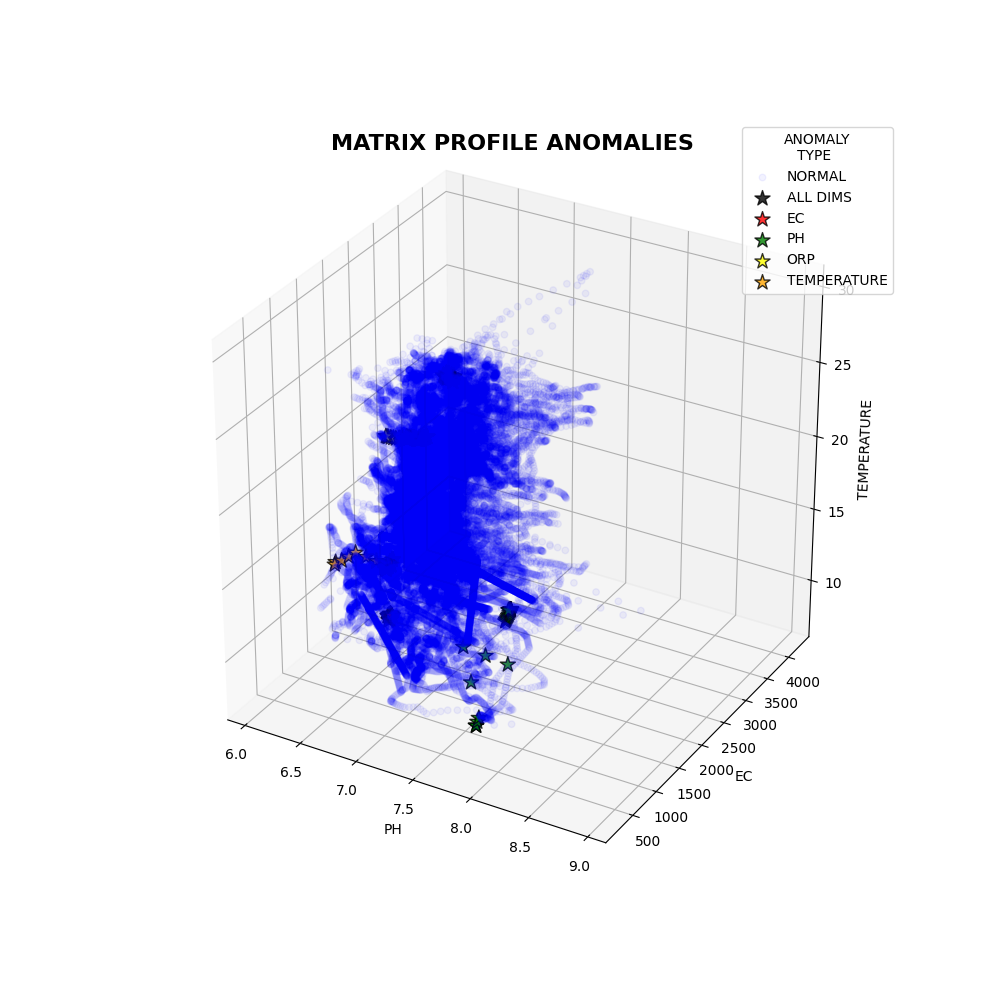

In [8]:
plot__matrix_profile_anomalies(df)

<div class="alert alert-info"><b>&emsp;<u>ISOLATION FOREST ANOMALIES </u></b>

In [9]:
df = add_isolation_forest_anomalies_labels(df)

/home/ron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ron/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ron/anaconda3/lib/python3.6/sit

<IPython.core.display.Javascript object>


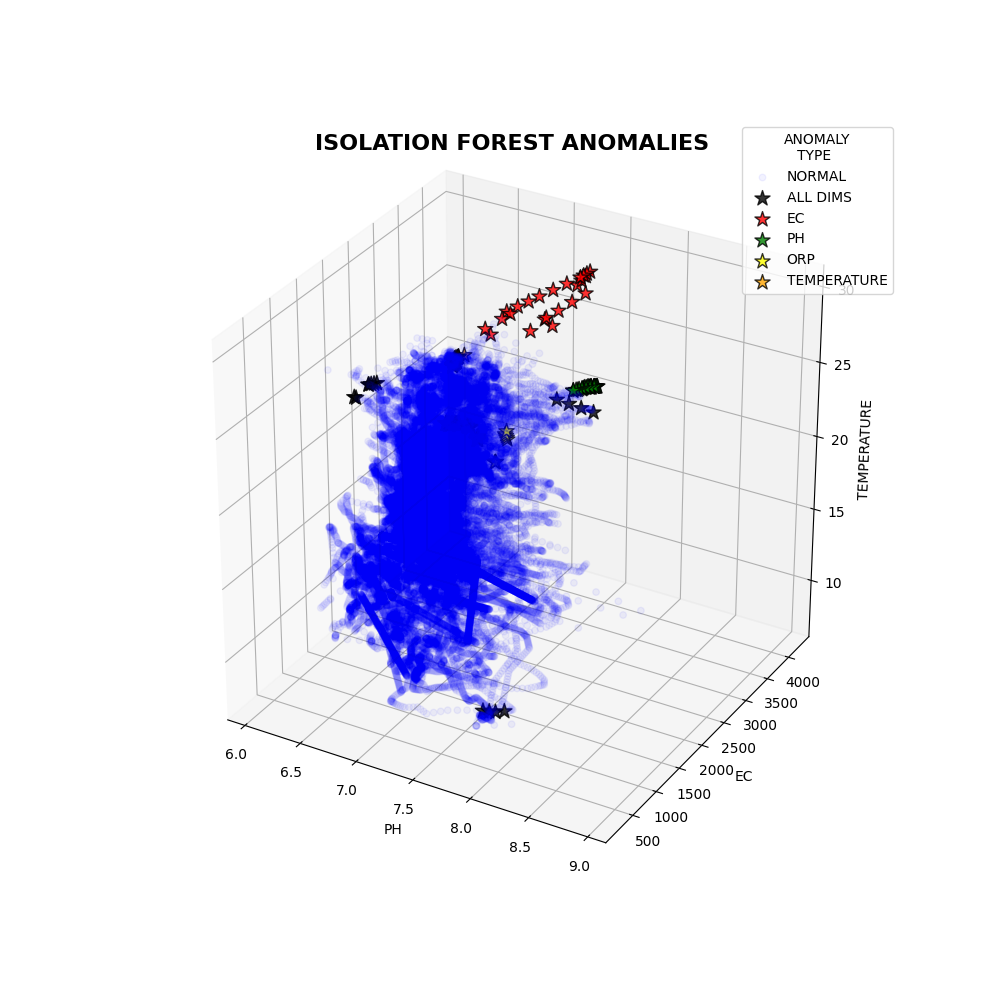

In [10]:
plot__isolation_forest_anomalies(df)

<div class="alert alert-info"><b>&emsp;<u>AUTOENCODER ANOMALIES </u></b>

In [11]:
def vae_input_preprocessing(df):
        # normalize the data
    x = df[['EC', 'PH', 'ORP', 'TEMPERATURE']].values  #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

        # reshape inputs for LSTM [samples, timesteps, features]
    vae_input = x_scaled.reshape(x_scaled.shape[0], 1, x_scaled.shape[1])
    return(vae_input)

In [15]:
# define the autoencoder network model

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [16]:
def add_vae_anomalies_labels(df, model):

    X_pred = model.predict(vae_input)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=['EC', 'PH', 'ORP', 'TEMPERATURE'])
    X_pred.index = df.index

    Xtrain = vae_input.reshape(vae_input.shape[0], vae_input.shape[2])

    scored_train = pd.DataFrame(index=df.index)
    scored_train['Loss_mae'] = np.mean(np.abs(X_pred - Xtrain), axis=1)

    df['auto encoder Anomaly'] = 0
    df['auto encoder Anomaly'][scored_train['Loss_mae'].nlargest(
        n=WINDOW, keep='first').index] = 1
    return (df)

In [30]:
def plot_vae_anomalies(df):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(2):
        x = df['PH'][df['auto encoder Anomaly'] == i]
        y = df['EC'][df['auto encoder Anomaly'] == i]
        z = df['TEMPERATURE'][df['auto encoder Anomaly'] == i]

        if i == 0:
            tmp_size = 90
            tmp_alpha = 0.05
            tmp_edgecolor = None
            color = 'blue'
            label = 'NORMAL'
            marker = '.'
        else:
            tmp_size = 130
            tmp_alpha = 0.8
            tmp_edgecolor = 'black'
            color = 'black'
            label = 'ALL DIMS'
            marker = '*'


        scatter = ax.scatter(x,
                             y,
                             z,
                             c=color,
                             marker=marker,
                             cmap=plt.cm.Spectral_r,
                             alpha=tmp_alpha,
                             s=tmp_size,
                             edgecolor=tmp_edgecolor,
                             label=label)
    plt.legend(title=' TYPE')

    ax.set_xlabel('PH')
    ax.set_ylabel('EC')
    ax.set_zlabel('TEMPERATURE')

    plt.title('AUTO ENCODER ANOMALIES\n', FontSize=16, FontWeight='bold')

    plt.show()

In [27]:
vae_input = vae_input_preprocessing(df)

# create the autoencoder model

model = autoencoder_model(vae_input)
model.compile(optimizer='adam', loss='mae' , metrics=['accuracy'])
model.summary()

# fit the model to the data

nb_epochs = 100
batch_size = WINDOW
history = model.fit(vae_input, vae_input, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.15).history

df = add_vae_anomalies_labels(df, model)
plot_vae_anomalies(df)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)             

KeyboardInterrupt: 

<div class="alert alert-info"><b><u><center>EXTENDED ISOLATION FOREST ANOMALIES </center></u></b>

In [28]:
def add_extended_isolation_forest_anomalies_labels(df):
    # normalize the data
    x = df[['EC', 'PH', 'ORP', 'TEMPERATURE']].values  #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    if_eif = iso.iForest(x_scaled,
                         ntrees=100,
                         sample_size=256,
                         ExtensionLevel=3)

    # calculate anomaly scores
    anomaly_scores = if_eif.compute_paths(X_in=x_scaled)
    max_indices = anomaly_scores.argsort()[-WINDOW:][::-1]
    df['ALL_DIMS_eif'] = 0
    df['ALL_DIMS_eif'][max_indices] = 1
    
    indx = np.arange(df.shape[0])
    for col in ['EC', 'PH', 'ORP', 'TEMPERATURE']:
        df[f'{col}_eif'] = 0
        values = df[col].values
        tempdf = pd.DataFrame({
            'time': indx,
            'ph': values,
        })
        anomaly_score = iso.iForest(tempdf.values, 
                         ntrees = 100, 
                         sample_size = 256, 
                         ExtensionLevel = 1)
        anomaly_scores = if_eif.compute_paths(X_in = tempdf.values)
        max_indices = anomaly_scores.argsort()[-WINDOW:][::-1]
        df[f'{col}_eif'][max_indices] = 1

    df['NORMAL_eif'] = 1
    df['NORMAL_eif'][(df['EC_eif'] == 1) | (df['PH_eif'] == 1) | (df['ORP_eif'] == 1) |
                    (df['TEMPERATURE_eif'] == 1) | (df['ALL_DIMS_eif'] == 1)] = 0
    return (df)

In [32]:
def plot_extended_isolation_forest(df):

    eif_cols = ['NORMAL_eif', 'ALL_DIMS_eif', 'EC_eif', 'PH_eif', 'ORP_eif', 'TEMPERATURE_eif', ]
    colors = ['blue', 'black', 'red', 'green', 'yellow', 'orange']
    labels = ['NORMAL', 'ALL DIMS', 'EC', 'PH', 'ORP', 'TEMPERATURE']

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(6):
        x = df['PH'][df[eif_cols[i]] == 1]
        y = df['EC'][df[eif_cols[i]] == 1]
        z = df['TEMPERATURE'][df[eif_cols[i]] == 1]

        tmp_color = colors[i]
        if i == 0:
            tmp_size = 90
            tmp_alpha = 0.05
            tmp_edgecolor = None
            marker = '.'
        else:
            tmp_size = 130
            tmp_alpha = 0.8
            tmp_edgecolor = 'black'
            marker = '*'

        scatter = ax.scatter(x,
                             y,
                             z,
                             c=colors[i],
                             marker=marker,
                             cmap=plt.cm.Spectral_r,
                             alpha=tmp_alpha,
                             s=tmp_size,
                             edgecolor=tmp_edgecolor,
                             label=labels[i])
    plt.legend(title=' TYPE')

    ax.set_xlabel('PH')
    ax.set_ylabel('EC')
    ax.set_zlabel('TEMPERATURE')

    plt.title('EXTENDED ISOLATION FOREST ANOMALIES\n', FontSize=16, FontWeight='bold')

    plt.show()

/home/ron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ron/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ron

<IPython.core.display.Javascript object>


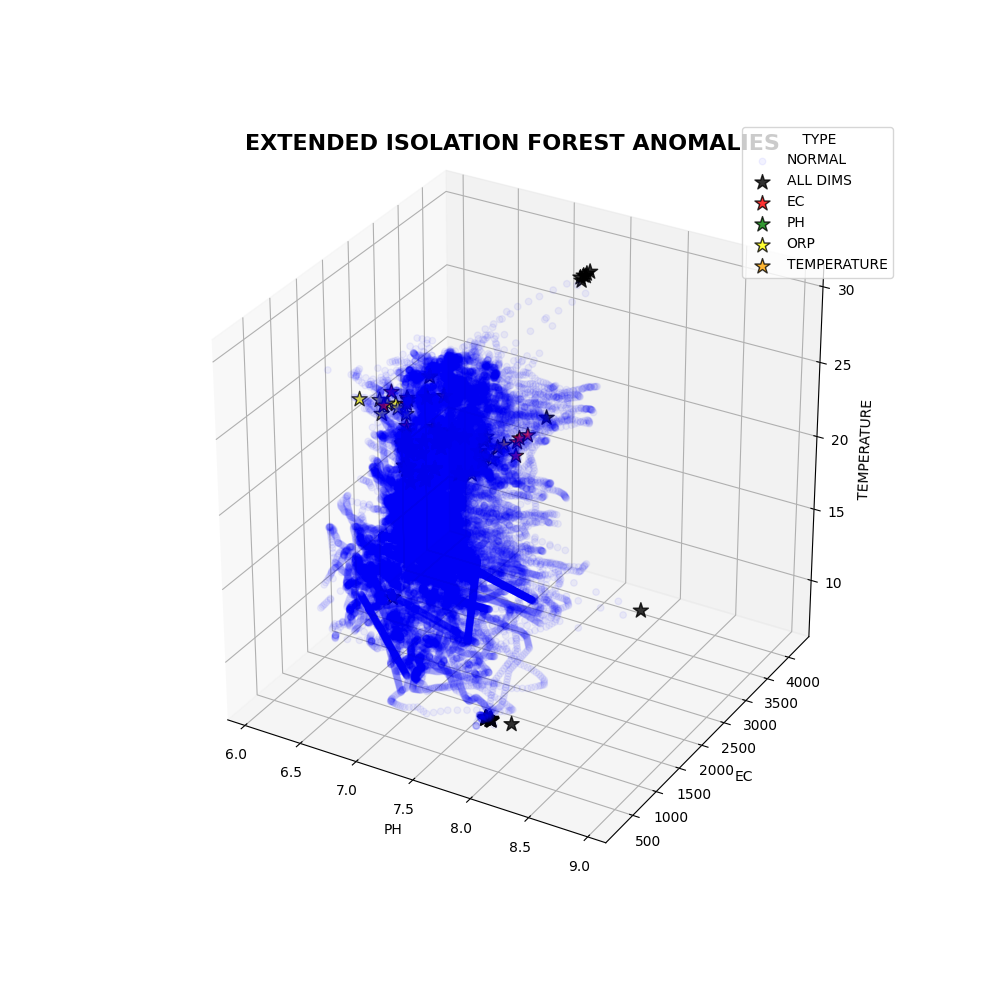

In [33]:
df = add_extended_isolation_forest_anomalies_labels(df)
plot_extended_isolation_forest(df)

In [ ]:
def save_df_with_anomalies(df, point_id):
    b_file = open(f"{point_id}_data_with_anomalies.pkl", "wb")
    pickle.dump(df, b_file)
    b_file.close()

In [ ]:
save_df_with_anomalies(df, 911)